# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## split 

In [15]:
ds = dataset_cc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27238
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6810
    })
})

In [16]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})


## test dataset

In [17]:
notebook_login()

In [18]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [19]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [20]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [21]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [22]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [23]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

## label balance

<Axes: ylabel='count'>

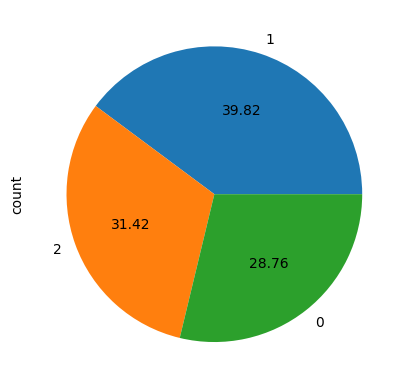

In [25]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

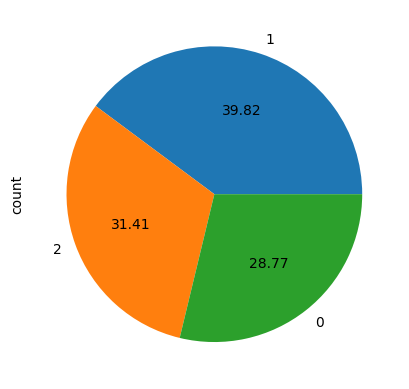

In [26]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

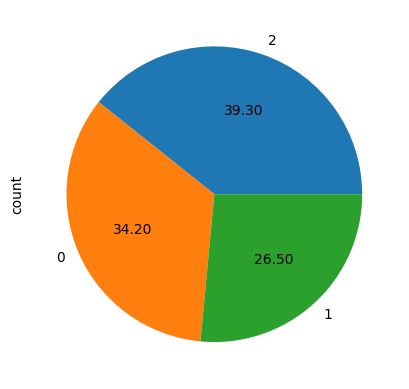

In [27]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

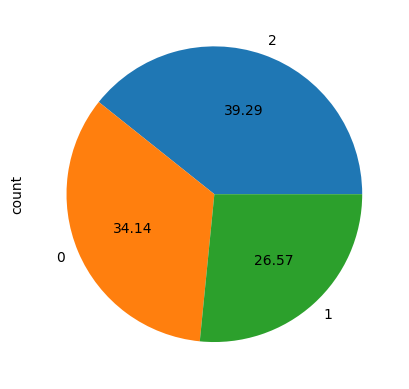

In [28]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [29]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27238
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6810
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})


In [30]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [31]:
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [32]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27238 [00:00<?, ? examples/s]

Map:   0%|          | 0/6810 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [33]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [34]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [36]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [37]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [40]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-07 16:48:38,256] A new study created in memory with name: no-name-aa0dca1a-e66f-4b6a-9e9f-1bf304e7a846
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6241, 'learning_rate': 7.77514609743673e-05, 'epoch': 0.66}
{'eval_loss': 0.5479660034179688, 'eval_accuracy': 0.7709251101321586, 'eval_f1': 0.7742214802071455, 'eval_precision': 0.7710480542679701, 'eval_recall': 0.7800798432726271, 'eval_runtime': 39.482, 'eval_samples_per_second': 172.484, 'eval_steps_per_second': 21.579, 'epoch': 0.66}
{'loss': 0.4719, 'learning_rate': 3.9412476273002754e-05, 'epoch': 1.32}
{'eval_loss': 0.5646504759788513, 'eval_accuracy': 0.7864904552129222, 'eval_f1': 0.790042716757594, 'eval_precision': 0.7900333570554386, 'eval_recall': 0.7901591490841282, 'eval_runtime': 39.3589, 'eval_samples_per_second': 173.023, 'eval_steps_per_second': 21.647, 'epoch': 1.32}
{'loss': 0.3706, 'learning_rate': 1.0734915716382076e-06, 'epoch': 1.98}
{'eval_loss': 0.5449013113975525, 'eval_accuracy': 0.7895741556534508, 'eval_f1': 0.7930561994553488, 'eval_precision': 0.7913443737511291, 'eval_recall': 0.7952212476813791, 'eval_runtime': 39.3286, 'eval_samples_per

[I 2023-12-07 17:22:30,269] Trial 0 finished with value: 3.169195976541308 and parameters: {'learning_rate': 0.00011609044567573186, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 0 with value: 3.169195976541308.
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,▂█▁
eval/precision,▁██
eval/recall,▁▆█
eval/runtime,█▂▁
eval/samples_per_second,▁▇█
eval/steps_per_second,▁▇█
train/epoch,▁▁▄▄███
train/global_step,▁▁▄▄███
train/learning_rate,█▅▁


{'loss': 0.5615, 'learning_rate': 1.3317579513556005e-06, 'epoch': 0.66}
{'eval_loss': 0.5279771685600281, 'eval_accuracy': 0.77856093979442, 'eval_f1': 0.7825580810164791, 'eval_precision': 0.7807164074190647, 'eval_recall': 0.784830579672405, 'eval_runtime': 39.2948, 'eval_samples_per_second': 173.305, 'eval_steps_per_second': 21.682, 'epoch': 0.66}


[I 2023-12-07 17:40:39,917] Trial 1 finished with value: 3.1266660079023687 and parameters: {'learning_rate': 3.922726728312022e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 36}. Best is trial 0 with value: 3.169195976541308.


{'train_runtime': 1087.5199, 'train_samples_per_second': 25.046, 'train_steps_per_second': 0.696, 'train_loss': 0.5483126319068898, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.6181, 'learning_rate': 4.081257674600245e-05, 'epoch': 0.29}
{'eval_loss': 0.5587738752365112, 'eval_accuracy': 0.7700440528634361, 'eval_f1': 0.7746091700478358, 'eval_precision': 0.7904729872566358, 'eval_recall': 0.768569909406449, 'eval_runtime': 39.6301, 'eval_samples_per_second': 171.839, 'eval_steps_per_second': 21.499, 'epoch': 0.29}
{'loss': 0.5716, 'learning_rate': 3.638508957459841e-05, 'epoch': 0.59}
{'eval_loss': 0.5565372109413147, 'eval_accuracy': 0.7787077826725404, 'eval_f1': 0.7817869896239004, 'eval_precision': 0.7819003856053311, 'eval_recall': 0.7840771348964259, 'eval_runtime': 39.6463, 'eval_samples_per_second': 171.769, 'eval_steps_per_second': 21.49, 'epoch': 0.59}
{'loss': 0.5562, 'learning_rate': 3.195760240319437e-05, 'epoch': 0.88}
{'eval_loss': 0.5532259345054626, 'eval_accuracy': 0.7719530102790014, 'eval_f1': 0.7746595683801972, 'eval_precision': 0.7722103007779012, 'eval_recall': 0.7819579223925183, 'eval_runtime': 39.653, 'eval_samples_per_s

[I 2023-12-07 18:15:19,563] Trial 2 finished with value: 3.137361018225318 and parameters: {'learning_rate': 4.524006391740649e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 3.169195976541308.


{'train_runtime': 2077.0063, 'train_samples_per_second': 39.342, 'train_steps_per_second': 2.46, 'train_loss': 0.4030201733287334, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▅▂█▆█▄▆▇▆
eval/f1,▁▄▁█▆█▃▆▇▆
eval/loss,▁▁▁▁▂▂▆▆█▇
eval/precision,█▅▁▇▆▇▃▅▇▅
eval/recall,▁▅▅█▆█▆▇▇▆
eval/runtime,▁▂▃▂▃▅▃█▆█
eval/samples_per_second,█▇▆▇▆▄▆▁▂▁
eval/steps_per_second,█▇▆▇▆▄▆▁▂▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
train/learning_rate,█▇▆▆▅▄▃▃▂▁


{'loss': 1.109, 'learning_rate': 0.0005784671692129757, 'epoch': 0.59}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0901824235916138, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.7548, 'eval_samples_per_second': 171.3, 'eval_steps_per_second': 21.431, 'epoch': 0.59}
{'loss': 1.0941, 'learning_rate': 0.00047900582650097845, 'epoch': 1.17}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0889087915420532, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.5445, 'eval_samples_per_second': 172.211, 'eval_steps_per_second': 21.545, 'epoch': 1.17}
{'loss': 1.0926, 'learning_rate': 0.0003795444837889813, 'epoch': 1.76}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0891520977020264, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.665, 'eval_samples_per_second': 171.688, 'eval_steps_per_second': 21.48, 'epoch': 1.76}
{'loss': 1.0906, 'learning_rate': 0.0002800831410769841, 'epoch': 2.35}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0896267890930176, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.6405, 'eval_samples_per_second': 171.794, 'eval_steps_per_second': 21.493, 'epoch': 2.35}
{'loss': 1.0899, 'learning_rate': 0.00018062179836498692, 'epoch': 2.93}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0899865627288818, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.6073, 'eval_samples_per_second': 171.938, 'eval_steps_per_second': 21.511, 'epoch': 2.93}
{'loss': 1.0909, 'learning_rate': 8.11604556529897e-05, 'epoch': 3.52}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0891457796096802, 'eval_accuracy': 0.39823788546255506, 'eval_f1': 0.1898760764545264, 'eval_precision': 0.1327459618208517, 'eval_recall': 0.3333333333333333, 'eval_runtime': 39.5599, 'eval_samples_per_second': 172.144, 'eval_steps_per_second': 21.537, 'epoch': 3.52}


[I 2023-12-07 18:51:13,847] Trial 3 finished with value: 1.0541932570712664 and parameters: {'learning_rate': 0.0006779285119249728, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 3.169195976541308.


{'train_runtime': 2152.1804, 'train_samples_per_second': 50.624, 'train_steps_per_second': 1.584, 'train_loss': 1.0938564891546545, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▁▁▁▁▁
eval/f1,▁▁▁▁▁▁
eval/loss,█▁▂▅▇▂
eval/precision,▁▁▁▁▁▁
eval/recall,▁▁▁▁▁▁
eval/runtime,█▁▅▄▃▂
eval/samples_per_second,▁█▄▅▆▇
eval/steps_per_second,▁█▄▅▆█
train/epoch,▁▁▂▂▃▃▅▅▆▆▇▇█
train/global_step,▁▁▂▂▃▃▅▅▆▆▇▇█
train/learning_rate,█▇▅▄▂▁


{'loss': 0.5868, 'learning_rate': 7.008513267876125e-07, 'epoch': 0.44}
{'eval_loss': 0.561499834060669, 'eval_accuracy': 0.761086637298091, 'eval_f1': 0.7651669839621648, 'eval_precision': 0.7622690343762478, 'eval_recall': 0.770744053334982, 'eval_runtime': 39.7248, 'eval_samples_per_second': 171.429, 'eval_steps_per_second': 21.448, 'epoch': 0.44}
{'loss': 0.5676, 'learning_rate': 1.489998883721696e-07, 'epoch': 0.88}
{'eval_loss': 0.5488317012786865, 'eval_accuracy': 0.765345080763583, 'eval_f1': 0.7692224064887668, 'eval_precision': 0.7658223285001818, 'eval_recall': 0.7750585481838356, 'eval_runtime': 39.7593, 'eval_samples_per_second': 171.281, 'eval_steps_per_second': 21.429, 'epoch': 0.88}


[I 2023-12-07 19:01:02,062] Trial 4 finished with value: 3.0754483639363674 and parameters: {'learning_rate': 1.2527027652030555e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 24}. Best is trial 0 with value: 3.169195976541308.


{'train_runtime': 586.1029, 'train_samples_per_second': 46.473, 'train_steps_per_second': 1.937, 'train_loss': 0.5714610162810607, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▆▆█
train/global_step,▁▁▇▇█
train/learning_rate,█▁


{'loss': 0.5662, 'learning_rate': 2.414098945721964e-06, 'epoch': 0.66}
{'eval_loss': 0.5313547253608704, 'eval_accuracy': 0.7767988252569751, 'eval_f1': 0.780740584138342, 'eval_precision': 0.7779992568210391, 'eval_recall': 0.7848860784100683, 'eval_runtime': 39.1561, 'eval_samples_per_second': 173.919, 'eval_steps_per_second': 21.759, 'epoch': 0.66}
{'loss': 0.5138, 'learning_rate': 1.936626844115563e-06, 'epoch': 1.32}
{'eval_loss': 0.5210484862327576, 'eval_accuracy': 0.7832599118942731, 'eval_f1': 0.7865849409890497, 'eval_precision': 0.7872733051371794, 'eval_recall': 0.7871944698808709, 'eval_runtime': 39.1334, 'eval_samples_per_second': 174.02, 'eval_steps_per_second': 21.772, 'epoch': 1.32}
{'loss': 0.4923, 'learning_rate': 1.4591547425091618e-06, 'epoch': 1.98}
{'eval_loss': 0.5212540626525879, 'eval_accuracy': 0.7863436123348018, 'eval_f1': 0.7899854601129985, 'eval_precision': 0.7870059495538403, 'eval_recall': 0.7945759812388328, 'eval_runtime': 39.0882, 'eval_samples_per

[I 2023-12-07 21:19:06,637] Trial 5 finished with value: 3.1787720760982427 and parameters: {'learning_rate': 2.891571047328365e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 36}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 8282.5498, 'train_samples_per_second': 13.154, 'train_steps_per_second': 0.366, 'train_loss': 0.4944990314297191, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▄▅▇██
eval/f1,▁▄▅▇██
eval/loss,█▃▃▁▁▃
eval/precision,▁▅▅▇██
eval/recall,▁▂▆▆▇█
eval/runtime,▄▃▁▁▇█
eval/samples_per_second,▅▆██▂▁
eval/steps_per_second,▅▆██▂▁
train/epoch,▁▁▂▂▄▄▅▅▇▇███
train/global_step,▁▁▂▂▄▄▅▅▇▇███
train/learning_rate,█▇▅▄▂▁


{'loss': 0.5256, 'learning_rate': 1.6868393519798245e-05, 'epoch': 1.03}
{'eval_loss': 0.5347051024436951, 'eval_accuracy': 0.7922173274596183, 'eval_f1': 0.7954114897131994, 'eval_precision': 0.7924419890469129, 'eval_recall': 0.7999747995272006, 'eval_runtime': 39.098, 'eval_samples_per_second': 174.178, 'eval_steps_per_second': 21.791, 'epoch': 1.03}
{'loss': 0.4124, 'learning_rate': 1.2509635504346502e-05, 'epoch': 2.05}
{'eval_loss': 0.5804806351661682, 'eval_accuracy': 0.7942731277533039, 'eval_f1': 0.7975021163747339, 'eval_precision': 0.7950459303800482, 'eval_recall': 0.8010985225799976, 'eval_runtime': 39.1412, 'eval_samples_per_second': 173.985, 'eval_steps_per_second': 21.767, 'epoch': 2.05}
{'loss': 0.3285, 'learning_rate': 8.150877488894758e-06, 'epoch': 3.08}
{'eval_loss': 0.6508191823959351, 'eval_accuracy': 0.7938325991189428, 'eval_f1': 0.7969005643267941, 'eval_precision': 0.793852753156033, 'eval_recall': 0.8019337937480162, 'eval_runtime': 39.2083, 'eval_samples_pe

[I 2023-12-08 05:22:39,532] Trial 6 finished with value: 3.168337231794184 and parameters: {'learning_rate': 2.1227151535249987e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 56}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 29010.6546, 'train_samples_per_second': 4.694, 'train_steps_per_second': 0.084, 'train_loss': 0.34892979804005714, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▅█▇▁
eval/f1,▅█▇▁
eval/loss,▁▃▆█
eval/precision,▃█▆▁
eval/recall,▆▇█▁
eval/runtime,▁▄█▅
eval/samples_per_second,█▅▁▄
eval/steps_per_second,█▅▁▄
train/epoch,▁▁▃▃▅▅▆▆█
train/global_step,▁▁▃▃▅▅▆▆█
train/learning_rate,█▆▃▁


{'loss': 0.5357, 'learning_rate': 3.1760577216159113e-06, 'epoch': 1.17}
{'eval_loss': 0.5214064121246338, 'eval_accuracy': 0.7904552129221732, 'eval_f1': 0.7939451908870562, 'eval_precision': 0.7928337379284048, 'eval_recall': 0.7952529557019826, 'eval_runtime': 386.6961, 'eval_samples_per_second': 17.611, 'eval_steps_per_second': 2.203, 'epoch': 1.17}
{'loss': 0.4796, 'learning_rate': 1.1348895200632692e-06, 'epoch': 2.35}
{'eval_loss': 0.5139705538749695, 'eval_accuracy': 0.7898678414096917, 'eval_f1': 0.7935790388187159, 'eval_precision': 0.7931815535630958, 'eval_recall': 0.7940684224465063, 'eval_runtime': 386.2986, 'eval_samples_per_second': 17.629, 'eval_steps_per_second': 2.206, 'epoch': 2.35}


[I 2023-12-08 10:38:53,644] Trial 7 finished with value: 3.17069685623801 and parameters: {'learning_rate': 5.2172259231685535e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 18971.0987, 'train_samples_per_second': 4.307, 'train_steps_per_second': 0.067, 'train_loss': 0.49723906658811373, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,█▁
eval/f1,█▁
eval/loss,█▁
eval/precision,▁█
eval/recall,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▅▅█
train/learning_rate,█▁


{'loss': 0.5533, 'learning_rate': 1.2903696756373819e-06, 'epoch': 0.73}
{'eval_loss': 0.523880660533905, 'eval_accuracy': 0.7828193832599118, 'eval_f1': 0.7863373076092292, 'eval_precision': 0.7831514748197739, 'eval_recall': 0.791368390683523, 'eval_runtime': 39.181, 'eval_samples_per_second': 173.809, 'eval_steps_per_second': 21.745, 'epoch': 0.73}


[I 2023-12-08 11:22:34,539] Trial 8 finished with value: 3.143676556372438 and parameters: {'learning_rate': 4.8549267906577735e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 40}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 2618.0636, 'train_samples_per_second': 10.404, 'train_steps_per_second': 0.26, 'train_loss': 0.5427696463295016, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.603, 'learning_rate': 1.8540162118491966e-05, 'epoch': 0.88}
{'eval_loss': 0.5288662910461426, 'eval_accuracy': 0.7784140969162996, 'eval_f1': 0.7809701798486186, 'eval_precision': 0.7795088073288946, 'eval_recall': 0.7849107355400596, 'eval_runtime': 39.0861, 'eval_samples_per_second': 174.231, 'eval_steps_per_second': 21.798, 'epoch': 0.88}


[I 2023-12-08 12:31:38,187] Trial 9 finished with value: 3.1238038196338724 and parameters: {'learning_rate': 0.00015486488357799172, 'num_train_epochs': 1, 'per_device_train_batch_size': 48}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 4141.4447, 'train_samples_per_second': 6.577, 'train_steps_per_second': 0.137, 'train_loss': 0.5889254892376107, 'epoch': 1.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.5724, 'learning_rate': 8.88146725218439e-07, 'epoch': 1.32}


[I 2023-12-08 15:14:41,489] Trial 10 pruned. 


{'eval_loss': 0.5402680039405823, 'eval_accuracy': 0.768575624082232, 'eval_f1': 0.7724174214963199, 'eval_precision': 0.7694486717448902, 'eval_recall': 0.7782851768565687, 'eval_runtime': 472.3264, 'eval_samples_per_second': 14.418, 'eval_steps_per_second': 1.804, 'epoch': 1.32}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.527, 'learning_rate': 4.764536190714087e-06, 'epoch': 1.17}
{'eval_loss': 0.5217233300209045, 'eval_accuracy': 0.7911894273127753, 'eval_f1': 0.7948594628280974, 'eval_precision': 0.7935327121352018, 'eval_recall': 0.7963657559328858, 'eval_runtime': 386.0183, 'eval_samples_per_second': 17.642, 'eval_steps_per_second': 2.207, 'epoch': 1.17}
{'loss': 0.4607, 'learning_rate': 1.7024949370417945e-06, 'epoch': 2.35}
{'eval_loss': 0.5153166651725769, 'eval_accuracy': 0.7894273127753304, 'eval_f1': 0.7931970623319528, 'eval_precision': 0.7932945612616117, 'eval_recall': 0.793315993501411, 'eval_runtime': 386.5243, 'eval_samples_per_second': 17.619, 'eval_steps_per_second': 2.204, 'epoch': 2.35}


[I 2023-12-08 20:48:18,439] Trial 11 finished with value: 3.169234929870306 and parameters: {'learning_rate': 7.826577444386379e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 5 with value: 3.1787720760982427.


{'train_runtime': 20013.9056, 'train_samples_per_second': 4.083, 'train_steps_per_second': 0.064, 'train_loss': 0.4811446021233739, 'epoch': 3.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,█▁
eval/f1,█▁
eval/loss,█▁
eval/precision,█▁
eval/recall,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▆▆█
train/global_step,▁▁▅▅█
train/learning_rate,█▁


{'loss': 0.5203, 'learning_rate': 7.877081009248425e-06, 'epoch': 1.17}
{'eval_loss': 0.5349186062812805, 'eval_accuracy': 0.7910425844346549, 'eval_f1': 0.7944774059956327, 'eval_precision': 0.7914520694604302, 'eval_recall': 0.7991919782842474, 'eval_runtime': 385.4051, 'eval_samples_per_second': 17.67, 'eval_steps_per_second': 2.211, 'epoch': 1.17}
{'loss': 0.4396, 'learning_rate': 4.605867965540608e-06, 'epoch': 2.35}
{'eval_loss': 0.5247179269790649, 'eval_accuracy': 0.7911894273127753, 'eval_f1': 0.7948373474653357, 'eval_precision': 0.7955520838586847, 'eval_recall': 0.7944358599343063, 'eval_runtime': 386.4752, 'eval_samples_per_second': 17.621, 'eval_steps_per_second': 2.205, 'epoch': 2.35}
{'loss': 0.39, 'learning_rate': 1.3346549218327896e-06, 'epoch': 3.52}
{'eval_loss': 0.5352835059165955, 'eval_accuracy': 0.7933920704845815, 'eval_f1': 0.7968384458197818, 'eval_precision': 0.7955780069284057, 'eval_recall': 0.7983296302601769, 'eval_runtime': 387.096, 'eval_samples_per_se

[I 2023-12-09 04:22:13,554] Trial 12 finished with value: 3.184138153492946 and parameters: {'learning_rate': 1.1148294052956244e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.184138153492946.


{'train_runtime': 27232.2932, 'train_samples_per_second': 4.001, 'train_steps_per_second': 0.063, 'train_loss': 0.44024220766595834, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▁█
eval/f1,▁▂█
eval/loss,█▁█
eval/precision,▁██
eval/recall,█▁▇
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.5161, 'learning_rate': 1.0283601312252623e-05, 'epoch': 1.17}
{'eval_loss': 0.5519813895225525, 'eval_accuracy': 0.7878120411160059, 'eval_f1': 0.7907877207737414, 'eval_precision': 0.7873932749835726, 'eval_recall': 0.7986954893558632, 'eval_runtime': 416.9603, 'eval_samples_per_second': 16.332, 'eval_steps_per_second': 2.043, 'epoch': 1.17}
{'loss': 0.4222, 'learning_rate': 6.013002760652697e-06, 'epoch': 2.35}
{'eval_loss': 0.5403670072555542, 'eval_accuracy': 0.7916299559471366, 'eval_f1': 0.7952049231641266, 'eval_precision': 0.7944442789346867, 'eval_recall': 0.7961975715082271, 'eval_runtime': 414.9828, 'eval_samples_per_second': 16.41, 'eval_steps_per_second': 2.053, 'epoch': 2.35}
{'loss': 0.3615, 'learning_rate': 1.7424042090527701e-06, 'epoch': 3.52}
{'eval_loss': 0.5551408529281616, 'eval_accuracy': 0.7922173274596183, 'eval_f1': 0.7957329357614324, 'eval_precision': 0.7941938099422159, 'eval_recall': 0.7975639609309922, 'eval_runtime': 415.3179, 'eval_samples_pe

[I 2023-12-09 11:50:31,825] Trial 13 finished with value: 3.179708034094259 and parameters: {'learning_rate': 1.4554199863852551e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.184138153492946.


{'train_runtime': 26895.5617, 'train_samples_per_second': 4.051, 'train_steps_per_second': 0.063, 'train_loss': 0.4214002179427886, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,▇▁█
eval/precision,▁██
eval/recall,█▁▅
eval/runtime,█▁▂
eval/samples_per_second,▁█▇
eval/steps_per_second,▁█▇
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.512, 'learning_rate': 1.81896332697879e-05, 'epoch': 1.17}
{'eval_loss': 0.5837584733963013, 'eval_accuracy': 0.7814977973568282, 'eval_f1': 0.7836965771353652, 'eval_precision': 0.7821435682994823, 'eval_recall': 0.7963523487075493, 'eval_runtime': 386.0764, 'eval_samples_per_second': 17.639, 'eval_steps_per_second': 2.207, 'epoch': 1.17}
{'loss': 0.3864, 'learning_rate': 1.0635798855424156e-05, 'epoch': 2.35}
{'eval_loss': 0.5903171300888062, 'eval_accuracy': 0.7900146842878121, 'eval_f1': 0.7932818462193004, 'eval_precision': 0.7907000394750926, 'eval_recall': 0.7969600645179749, 'eval_runtime': 384.9172, 'eval_samples_per_second': 17.692, 'eval_steps_per_second': 2.213, 'epoch': 2.35}
{'loss': 0.2923, 'learning_rate': 3.0819644410604082e-06, 'epoch': 3.52}
{'eval_loss': 0.6372821927070618, 'eval_accuracy': 0.7872246696035242, 'eval_f1': 0.7907614962118176, 'eval_precision': 0.7890689303731908, 'eval_recall': 0.792795176637711, 'eval_runtime': 385.8231, 'eval_samples_per_

[I 2023-12-09 19:15:19,059] Trial 14 finished with value: 3.1598502728262434 and parameters: {'learning_rate': 2.5743467684151647e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.184138153492946.


{'train_runtime': 26684.3228, 'train_samples_per_second': 4.083, 'train_steps_per_second': 0.064, 'train_loss': 0.3790536598420479, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁█▆
eval/f1,▁█▆
eval/loss,▁▂█
eval/precision,▁█▇
eval/recall,▇█▁
eval/runtime,█▁▆
eval/samples_per_second,▁█▃
eval/steps_per_second,▁█▂
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.5188, 'learning_rate': 8.574983965841334e-06, 'epoch': 1.17}
{'eval_loss': 0.5399026274681091, 'eval_accuracy': 0.7895741556534508, 'eval_f1': 0.7928953139364711, 'eval_precision': 0.7896824117964312, 'eval_recall': 0.7982262773874317, 'eval_runtime': 174.3834, 'eval_samples_per_second': 39.052, 'eval_steps_per_second': 4.886, 'epoch': 1.17}
{'loss': 0.4337, 'learning_rate': 5.013944112917193e-06, 'epoch': 2.35}
{'eval_loss': 0.5287003517150879, 'eval_accuracy': 0.7929515418502202, 'eval_f1': 0.7965318368568162, 'eval_precision': 0.7969682155585711, 'eval_recall': 0.7964433376407308, 'eval_runtime': 174.703, 'eval_samples_per_second': 38.98, 'eval_steps_per_second': 4.877, 'epoch': 2.35}
{'loss': 0.3811, 'learning_rate': 1.45290425999305e-06, 'epoch': 3.52}
{'eval_loss': 0.5410488843917847, 'eval_accuracy': 0.7930983847283407, 'eval_f1': 0.7965473012422496, 'eval_precision': 0.7949975434858395, 'eval_recall': 0.7983858818953662, 'eval_runtime': 174.0963, 'eval_samples_per_se

[I 2023-12-10 02:17:31,682] Trial 15 finished with value: 3.183029111351796 and parameters: {'learning_rate': 1.2136023818765477e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.184138153492946.


{'train_runtime': 25329.911, 'train_samples_per_second': 4.301, 'train_steps_per_second': 0.067, 'train_loss': 0.43417930603027344, 'epoch': 4.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁██
eval/f1,▁██
eval/loss,▇▁█
eval/precision,▁█▆
eval/recall,▇▁█
eval/runtime,▄█▁
eval/samples_per_second,▅▁█
eval/steps_per_second,▅▁█
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▄▁


{'loss': 0.5237, 'learning_rate': 7.372822971202131e-06, 'epoch': 1.17}
{'eval_loss': 0.5354116559028625, 'eval_accuracy': 0.7906020558002936, 'eval_f1': 0.7941458229715361, 'eval_precision': 0.7912333624308806, 'eval_recall': 0.7986171175279986, 'eval_runtime': 39.362, 'eval_samples_per_second': 173.01, 'eval_steps_per_second': 21.645, 'epoch': 1.17}
{'loss': 0.4478, 'learning_rate': 5.111220832796569e-06, 'epoch': 2.35}
{'eval_loss': 0.5208039283752441, 'eval_accuracy': 0.7891336270190896, 'eval_f1': 0.7929423631134354, 'eval_precision': 0.7936413503526124, 'eval_recall': 0.792550484941719, 'eval_runtime': 39.3032, 'eval_samples_per_second': 173.269, 'eval_steps_per_second': 21.678, 'epoch': 2.35}
{'loss': 0.4013, 'learning_rate': 2.8496186943910074e-06, 'epoch': 3.52}
{'eval_loss': 0.5324080586433411, 'eval_accuracy': 0.7948604992657856, 'eval_f1': 0.7984691655180397, 'eval_precision': 0.7975353146665359, 'eval_recall': 0.7994857632811657, 'eval_runtime': 39.4118, 'eval_samples_per_

[I 2023-12-10 11:14:19,276] Trial 16 finished with value: 3.163775370981849 and parameters: {'learning_rate': 9.634425109607692e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 12 with value: 3.184138153492946.


{'train_runtime': 32204.9409, 'train_samples_per_second': 4.229, 'train_steps_per_second': 0.066, 'train_loss': 0.43115229897655794, 'epoch': 5.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▄▂█▁
eval/f1,▄▂█▁
eval/loss,▄▁▄█
eval/precision,▃▅█▁
eval/recall,▇▁█▄
eval/runtime,▅▁█▇
eval/samples_per_second,▄█▁▂
eval/steps_per_second,▄█▁▂
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.5499, 'learning_rate': 1.0002708753512927e-05, 'epoch': 0.44}
{'eval_loss': 0.519241988658905, 'eval_accuracy': 0.7854625550660793, 'eval_f1': 0.788911887125332, 'eval_precision': 0.793484400317903, 'eval_recall': 0.7859974158761776, 'eval_runtime': 40.2534, 'eval_samples_per_second': 169.178, 'eval_steps_per_second': 21.166, 'epoch': 0.44}
{'loss': 0.5274, 'learning_rate': 7.177084811842609e-06, 'epoch': 0.88}
{'eval_loss': 0.5147302746772766, 'eval_accuracy': 0.7933920704845815, 'eval_f1': 0.7965853086974456, 'eval_precision': 0.7941754566059362, 'eval_recall': 0.8002279024507444, 'eval_runtime': 40.2646, 'eval_samples_per_second': 169.131, 'eval_steps_per_second': 21.16, 'epoch': 0.88}
{'loss': 0.4374, 'learning_rate': 4.351460870172291e-06, 'epoch': 1.32}
{'eval_loss': 0.5246540904045105, 'eval_accuracy': 0.7944199706314243, 'eval_f1': 0.797671724868453, 'eval_precision': 0.7968034310246352, 'eval_recall': 0.799157001811936, 'eval_runtime': 40.2953, 'eval_samples_per_sec

[I 2023-12-10 11:34:01,010] Trial 17 finished with value: 3.1971953070094408 and parameters: {'learning_rate': 1.2828332695183246e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 24}. Best is trial 17 with value: 3.1971953070094408.


{'train_runtime': 1179.0597, 'train_samples_per_second': 46.203, 'train_steps_per_second': 1.925, 'train_loss': 0.4768730600499897, 'epoch': 2.0}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁▆▇█
eval/f1,▁▆▆█
eval/loss,▄▁█▂
eval/precision,▁▂▄█
eval/recall,▁█▇█
eval/runtime,▁▃▇█
eval/samples_per_second,█▆▂▁
eval/steps_per_second,█▆▂▁
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.5936, 'learning_rate': 4.788292214906285e-05, 'epoch': 0.44}


[I 2023-12-10 11:38:10,583] Trial 18 pruned. 


{'eval_loss': 0.5454087853431702, 'eval_accuracy': 0.7775330396475771, 'eval_f1': 0.7810148812607401, 'eval_precision': 0.7861386567879931, 'eval_recall': 0.7772615891747469, 'eval_runtime': 40.4061, 'eval_samples_per_second': 168.539, 'eval_steps_per_second': 21.086, 'epoch': 0.44}


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.5628, 'learning_rate': 1.918474017519597e-05, 'epoch': 0.44}


[I 2023-12-10 11:42:20,411] Trial 19 pruned. 


{'eval_loss': 0.5294262766838074, 'eval_accuracy': 0.7814977973568282, 'eval_f1': 0.7843574163108924, 'eval_precision': 0.7994513538503757, 'eval_recall': 0.7765128737673445, 'eval_runtime': 40.417, 'eval_samples_per_second': 168.494, 'eval_steps_per_second': 21.08, 'epoch': 0.44}


BestRun(run_id='17', objective=3.1971953070094408, hyperparameters={'learning_rate': 1.2828332695183246e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 24}, run_summary=None)

# Trainer

In [36]:
training_args = TrainingArguments(
    output_dir='./7aresults',          # output directory
    learning_rate=1.2828332695183246e-05,
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=24,  # batch size per device during training
    per_device_eval_batch_size=24,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.609000,0.556349,0.760352,0.764860,0.764855,0.768492
200,0.535600,0.545923,0.765051,0.768311,0.764784,0.776594
300,0.532800,0.554027,0.771219,0.775734,0.777859,0.782060
400,0.527000,0.530795,0.779295,0.782684,0.783454,0.782446
500,0.535400,0.547750,0.773715,0.777294,0.774852,0.786064
600,0.526500,0.513252,0.784728,0.788686,0.788834,0.788620
700,0.511200,0.502806,0.788840,0.792567,0.795901,0.790001
800,0.505900,0.531270,0.788399,0.791513,0.788347,0.798142
900,0.506800,0.505044,0.790602,0.794323,0.795207,0.793712
1000,0.515800,0.504686,0.787959,0.791113,0.788934,0.794274


In [37]:
train_out

TrainOutput(global_step=2270, training_loss=0.4753799135989555, metrics={'train_runtime': 1879.7518, 'train_samples_per_second': 28.98, 'train_steps_per_second': 1.208, 'total_flos': 7166683272075264.0, 'train_loss': 0.4753799135989555, 'epoch': 2.0})

# Confusion matrix

In [48]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [49]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [50]:
preds_output.metrics

{'test_loss': 0.8933888077735901,
 'test_accuracy': 0.653,
 'test_f1': 0.6358323949188175,
 'test_precision': 0.6883988223855418,
 'test_recall': 0.6319033095726017,
 'test_runtime': 5.4628,
 'test_samples_per_second': 183.056,
 'test_steps_per_second': 7.688}

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)

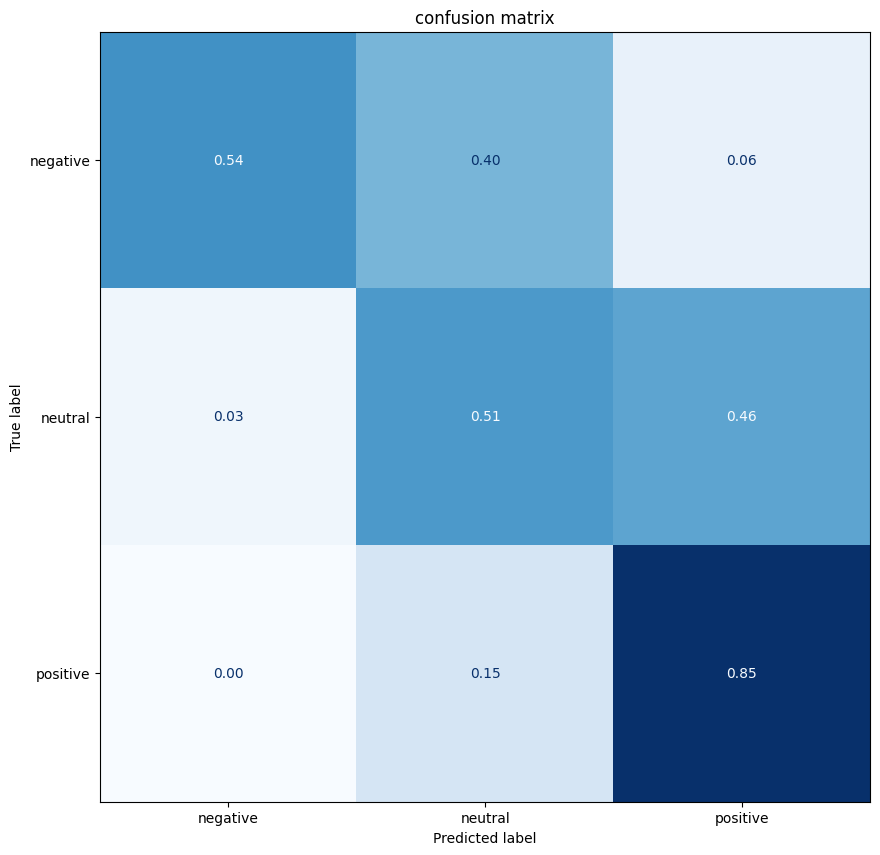

In [52]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation dataset

In [53]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [54]:
preds_output.metrics

{'test_loss': 0.5046862959861755,
 'test_accuracy': 0.7879588839941263,
 'test_f1': 0.7911134706844005,
 'test_precision': 0.7889336047597354,
 'test_recall': 0.7942743692227167,
 'test_runtime': 36.9391,
 'test_samples_per_second': 184.357,
 'test_steps_per_second': 7.688}

In [55]:
y_preds = np.argmax(preds_output.predictions, axis=1)

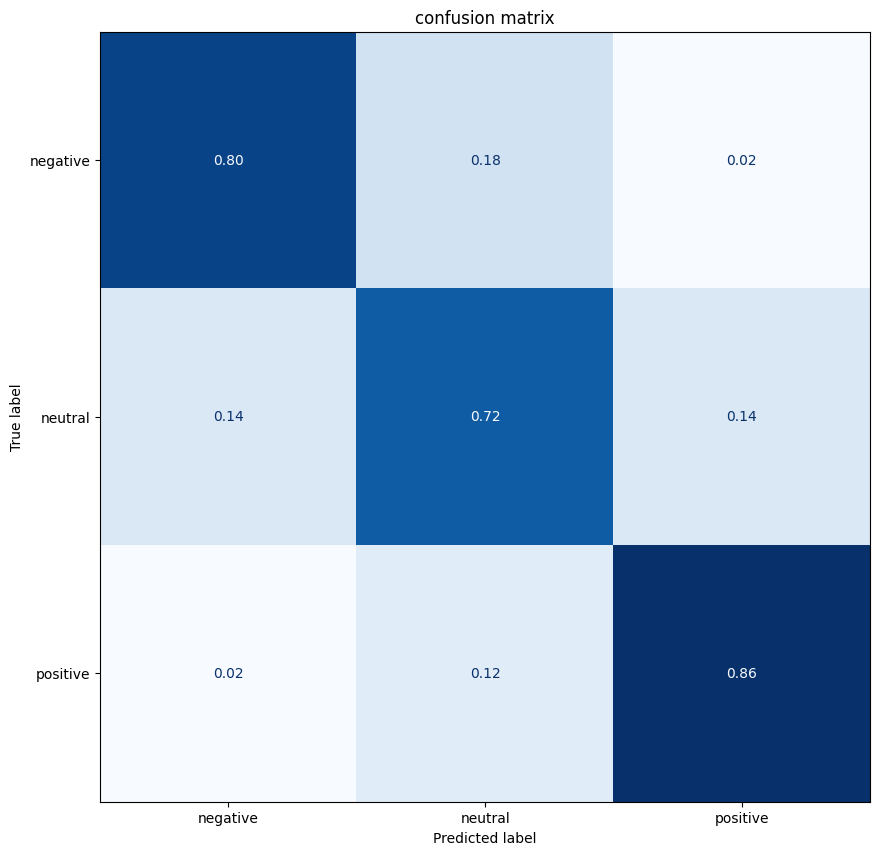

In [56]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [57]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>